# <font color="yellow">Training and Preprocessing</font>


# Library Imports and Environment Setup

### This section imports essential libraries, including tools for data processing, natural language processing, machine learning, and neural networks. It sets up foundational elements like TensorFlow/Keras, NLTK (for text preprocessing), and Scikit-Learn. For reproducibility, a random seed is defined.

In [1]:
# Standard Libraries
import os
import sys
import re
import random

# Numerical and Data Processing Libraries
import numpy as np
import pandas as pd

# Plotting Libraries
import matplotlib.pyplot as plt

# TensorFlow and Keras Libraries for Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

# Sklearn Libraries for Data Processing and Evaluation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# NLTK Libraries for Natural Language Processing
import nltk
# Download WordNet corpus
nltk.download('wordnet')
# Download the NLTK stopwords (if not already downloaded)
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Set Random Seed for Reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading and Preprocessing

### This section loads a dataset of tweets, filters for relevant emotions (like "sadness" and "happiness"), and renames columns for clarity. Unused categories are removed, label names are retrieved, and the data is split into training and testing sets. This setup prepares the data for further analysis and modeling.

In [2]:
import pandas as pd

# Load dataset and select relevant columns
df = pd.read_csv(
    'tweet_emotions.csv',  # Replace with the actual path to your dataset
    usecols=['content', 'sentiment'],  # Extract only the required columns
    dtype={'content': 'string', 'sentiment': 'category'}  # Ensure correct types
)

# Rename columns for easier access
df.rename(columns={'content': 'sentence', 'sentiment': 'label'}, inplace=True)

# Filter dataset for specific labels (e.g., "sadness" and "happiness")
df = df[(df['label'] == 'sadness') | (df['label'] == 'happiness')]

# Remove unused categories
df['label'] = df['label'].cat.remove_unused_categories()

# Get label names (classes)
label_names = df['label'].cat.categories.tolist()

# Split dataset into training and test sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Display information
print(f'Training Set Size: {len(train_df)}, Test Set Size: {len(test_df)}')
print(f'Label Names: {label_names}')


Training Set Size: 8299, Test Set Size: 2075
Label Names: ['happiness', 'sadness']


### **Filtering Dataset for Relevant Emotions**

In this code, we specifically filter the dataset to include only two emotions: **"sadness"** and **"happiness"**. While this reduces the broader spectrum of emotions, it is done intentionally to focus on a **more categorical and structured analysis**. 

#### **Why Limit Emotions?**
- **Purpose-Driven Simplification:** By narrowing the scope to "sadness" and "happiness," we ensure that the model can produce more **ranked and focused results**. This approach allows for better categorization and evaluation, which aligns with our specific objectives.
- **Enhanced Interpretability:** A smaller set of categories provides a clear and concise framework for sentiment analysis, making the results easier to understand and evaluate.
- **Relevance Over Breadth:** While it may seem biased to exclude other emotions, this approach is deliberately designed to meet our goals, where we prioritize **precision and structure** over diversity in emotions.

# Dataset Overview and Class Balancing

### This section presents samples from the training and test sets, visualizes label distribution, and computes class weights to address data imbalance, aiding model training.

Training Set Sample:
    label                                                                                                        sentence
  sadness                                                  &quot;My problem isn't that I miss you... 'cause I don't&quot;
  sadness That's it? It's done already? This is one proof that there's nothing fair in this world.   http://bit.ly/10UEMq
  sadness                                                            I am so hungry! And there is no food for me to steal
happiness Feet hurt...finally in bed...will not forget this crunch when it's over...very very productive day today though
  sadness                                                                                                  really ill atm

Test Set Sample:
    label                                                                                          sentence
  sadness                                                  looks like we're rained out for weekend climbing
  sadness    

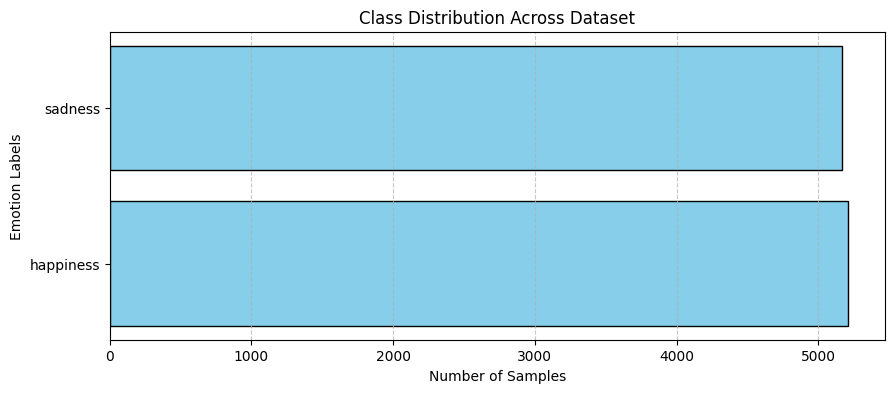


Calculated Class Weights: {0: 0.9957765406028029, 1: 1.0042594385285577}


In [3]:
# Displaying the first few records of the training and test sets
print("Training Set Sample:")
train_sample = train_df.head()
print(train_sample.to_string(index=False))

print("\nTest Set Sample:")
test_sample = test_df.head()
print(test_sample.to_string(index=False))

# Plotting class distribution with a different style
plt.figure(figsize=(10, 4))
plt.barh(label_names, np.bincount(df['label'].cat.codes), color='skyblue', edgecolor='black')
plt.title('Class Distribution Across Dataset')
plt.xlabel('Number of Samples')
plt.ylabel('Emotion Labels')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Retrieving class labels as a NumPy array for balanced weight computation
unique_classes = np.unique(df['label'].cat.codes)

# Calculating class weights to mitigate imbalance in training data
weights_dict = compute_class_weight(
    class_weight="balanced", 
    classes=unique_classes,
    y=df['label'].cat.codes
)

# Mapping class weights to respective labels and displaying them
class_weights_map = dict(enumerate(weights_dict))
print(f"\nCalculated Class Weights: {class_weights_map}")


This graph shows the class distribution across the dataset for the emotions "sadness" and "happiness." It highlights that both classes are equally represented, with around 5000 samples for each. The bars provide a clear of the data, showing that the model won't be biased toward one class over the other due to sample size.

# Section: Text Preprocessing

### This section defines text preprocessing steps, including regex-based cleaning, stopword removal, and lemmatization, essential for standardizing input text. It provides regex patterns for removing unwanted symbols, URLs, and numbers, alongside a `lemmatize_tokenize` function to tokenize, remove stopwords, and lemmatize words in the text. The sample usage demonstrates transforming raw input text into a cleaned, tokenized, and lemmatized format, ready for model input.

In [4]:
# Regex patterns for cleaning the text
REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@,;]')    # add/remove regex as required
BAD_SYMBOLS_RE = re.compile(r'[^0-9a-z #+_]')
NUMBERS_RE = re.compile(r'\d+')

# NLTK stopwords and lemmatizer
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Text Cleaning Function
def preprocess_text(input_text):
    input_text = tf.strings.lower(input_text)
    input_text = tf.strings.regex_replace(input_text, r'http\S+', '')
    input_text = tf.strings.regex_replace(input_text, r'[@#][A-Za-z0-9_]+', ' ')
    input_text = tf.strings.regex_replace(input_text, REPLACE_BY_SPACE_RE.pattern, ' ')  # Replace unwanted symbols with space
    input_text = tf.strings.regex_replace(input_text, BAD_SYMBOLS_RE.pattern, '')  # Remove bad symbols
    input_text = tf.strings.regex_replace(input_text, NUMBERS_RE.pattern, '')  # Remove numbers
    return input_text

# Function to tokenize, remove stopwords, and lemmatize
def lemmatize_tokenize(text):
    # Tokenize the text using TensorFlow, then process tokens
    tokens = tf.strings.split(text)  # Tokenize the text using TensorFlow's split
    tokens = tokens.numpy()  # Convert Tensor to NumPy array

    # Convert to Python strings and remove stopwords
    tokens = [token.decode('utf-8') for token in tokens if token.decode('utf-8') not in STOPWORDS]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Example usage
example_text = "This is a sample tweet! Visit https://example.com for more details. #example @user123"
cleaned_text = preprocess_text(example_text)

# Convert the TensorFlow Tensor to a NumPy string
cleaned_text_np = cleaned_text.numpy().decode('utf-8')

print("Cleaned Text:", cleaned_text_np)

tokenized_lemmatized = lemmatize_tokenize(cleaned_text_np)
print("Lemmatized and Tokenized:", tokenized_lemmatized)


Cleaned Text: this is a sample tweet visit  for more details    
Lemmatized and Tokenized: ['sample', 'tweet', 'visit', 'detail']


# Text Vectorization and Model Setup

### This section defines key text-processing and model parameters, including vocabulary and sequence length. The `TextVectorization` layer converts cleaned text into integer sequences, building a vocabulary from training data. Sample training sentences are shown in vectorized form to illustrate the preprocessing outcome.

In [5]:
# Setting hyperparameters for text processing and model
num_classes = len(label_names)       # The number of classes to predict
vocab_size = 5000                    # Limit the number of unique words in the vocabulary
sequence_length = 256                # Maximum number of words per sentence
embedding_size = 128                 # Size of the embedding vectors

# Create a TextVectorization layer to convert text to integer sequences
text_vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,             # Limit the vocab size
    standardize=preprocess_text,       # Clean text with the custom function
    output_sequence_length=sequence_length,  # Fixed sequence length
    output_mode='int'                  # Output integer IDs for words
)

# Build the vocabulary using the training sentences
text_vectorizer.adapt(train_df['sentence'])

# Display a formatted sample of vectorized text
print("\nVectorized Examples from Training Data:")

# Fetch a few sentences and their vectorized form
sample_sentences = train_df['sentence'].iloc[0:3].to_list()
vectorized_output = text_vectorizer(sample_sentences)

# Pretty-print the sentences and their vectorized form
for i, sentence in enumerate(sample_sentences):
    print(f"\nOriginal Sentence {i+1}: '{sentence}'")
    print(f"Vectorized (First 10 tokens): {vectorized_output[i].numpy()[:10]}")



Vectorized Examples from Training Data:

Original Sentence 1: '&quot;My problem isn't that I miss you... 'cause I don't&quot;'
Vectorized (First 10 tokens): [ 87   6 793 375  20   2  51   8 290   2]

Original Sentence 2: 'That's it? It's done already? This is one proof that there's nothing fair in this world.   http://bit.ly/10UEMq'
Vectorized (First 10 tokens): [111   9  25 192 176  31  10  55   1  20]

Original Sentence 3: 'I am so hungry! And there is no food for me to steal'
Vectorized (First 10 tokens): [  2  50  15 545   7  78  10  36 388  11]


# Text Classification Model Overview

### The model uses a `Sequential` setup with text vectorization, embedding, pooling, dropout layers, and a final softmax layer for classification. It is designed for sentiment prediction, compiled with the Adam optimizer, and evaluates performance via accuracy.

In [6]:
# Sequential model definition for text classification
classification_model = models.Sequential()

# Input layer: Accepts raw string input (sentences)
classification_model.add(keras.Input(shape=(1,), dtype=tf.string))

# Vectorization layer: Converts raw text to integer sequences
classification_model.add(text_vectorizer)

# Embedding layer: Transforms each word ID into a dense vector of size EMBEDDING_DIM
classification_model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_size))

# SpatialDropout1D: Randomly drops entire 1D feature maps to improve regularization
classification_model.add(layers.SpatialDropout1D(0.2))

# GlobalMaxPooling1D: Reduces each feature map to a single value (taking the maximum)
classification_model.add(layers.GlobalMaxPooling1D())

# Dropout layer to avoid overfitting
classification_model.add(layers.Dropout(0.4))

# Fully connected (Dense) layer with 'gelu' activation for non-linearity
classification_model.add(layers.Dense(256, activation='gelu'))

# Another Dropout layer for further regularization
classification_model.add(layers.Dropout(0.4))

# Final output layer: Softmax activation to classify the text into N_CLASSES
classification_model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model using the Adam optimizer and sparse categorical crossentropy for classification
classification_model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Summary of the model structure for a quick overview
classification_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 256)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 256, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 256, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,538 (2.57 MB)

 Trainable params: 673,538 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

# Training and Evaluating the Text Classifier

### 1. **Prepare Data:** Reset indices, then separate text and labels for training and testing sets.
### 2. **Train Model:** Run model training with early stopping to prevent overfitting.
### 3. **Evaluate:** Measure the model's accuracy on test data and print final accuracy for validation.

In [7]:
# Resetting index for both train and test sets to prevent any misalignment
train_data = train_df.reset_index(drop=True)
test_data = test_df.reset_index(drop=True)

# Separating the features (sentences) and labels from both training and testing sets
train_sentences, train_labels = train_data['sentence'], train_data['label'].cat.codes
test_sentences, test_labels = test_data['sentence'], test_data['label'].cat.codes

# Training the model
training_history = classification_model.fit(
    x=train_sentences,              # Training features: raw text sentences
    y=train_labels,                 # Training labels: integer-encoded
    validation_data=(test_sentences, test_labels),  # Validation data: raw text and labels
    batch_size=256,                 # Batch size for training
    epochs=300,                     # Maximum number of epochs
    verbose=1,                      # Progress output verbosity level
    class_weight=class_weights_map,  # Balancing class weights
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]  # Stop early if no improvement in 3 epochs
)

# Evaluate the model on test data
final_loss, final_accuracy = classification_model.evaluate(test_sentences, test_labels, verbose=2)

# Display the final accuracy on the test set
print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")


Epoch 1/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5247 - loss: 0.6916 - val_accuracy: 0.6704 - val_loss: 0.6721
Epoch 2/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6600 - loss: 0.6515 - val_accuracy: 0.7643 - val_loss: 0.5507
Epoch 3/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7788 - loss: 0.5029 - val_accuracy: 0.7913 - val_loss: 0.4488
Epoch 4/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8215 - loss: 0.4060 - val_accuracy: 0.7957 - val_loss: 0.4261
Epoch 5/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8657 - loss: 0.3384 - val_accuracy: 0.8053 - val_loss: 0.4180
Epoch 6/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8760 - loss: 0.3049 - val_accuracy: 0.8034 - val_loss: 0.4199
Epoch 7/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8948 - loss: 0.2662 - val_accuracy: 0.8101 - val_loss: 0.4270
Epoch 8/300
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9007 - loss: 0.2470 - val_accuracy: 0.

# Plotting Training and Validation History

### This function generates a side-by-side visualization of training history, showcasing accuracy and loss for both training and validation sets across epochs. 

### - **Left Plot:** Accuracy over epochs, comparing training and validation sets.
### - **Right Plot:** Loss over epochs, showing training and validation trends.
### - **Goal:** Provides an overview of the model’s performance improvement over time.

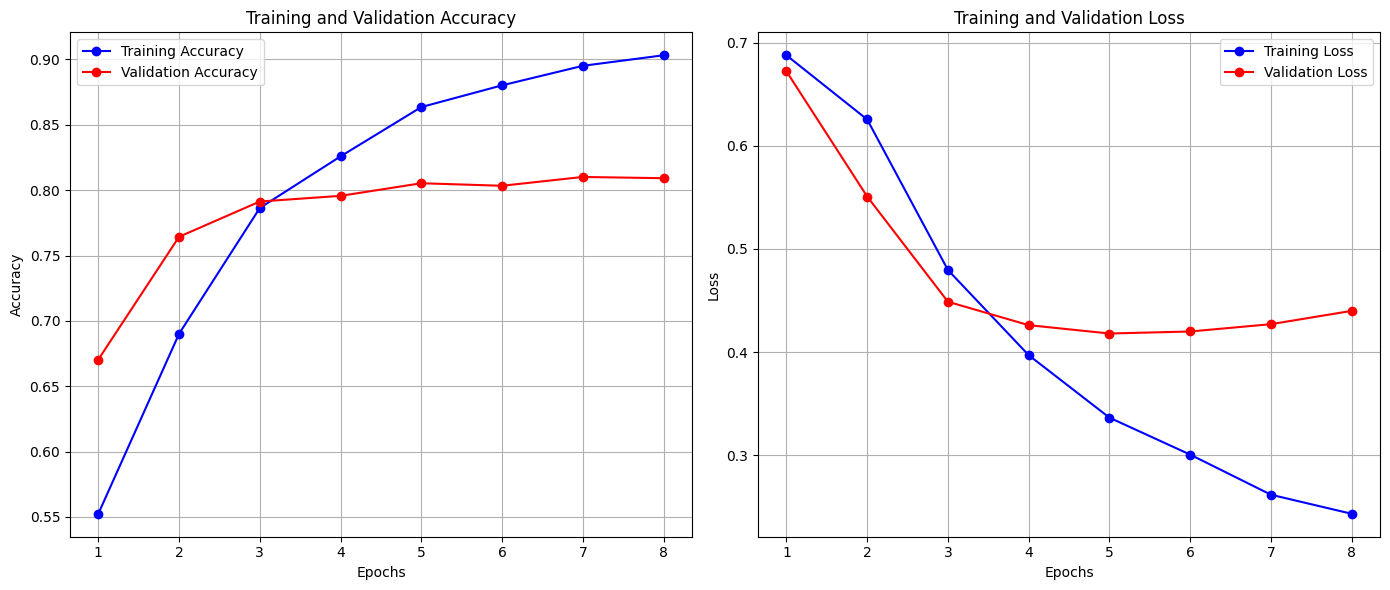

In [8]:
def plot_training_history(history):
    # Extract training history for accuracy and loss
    training_acc = history['accuracy']
    validation_acc = history['val_accuracy']
    training_loss = history['loss']
    validation_loss = history['val_loss']
    
    epochs_range = range(1, len(training_acc) + 1)  # X-axis values (epochs)
    
    # Set up the figure size for subplots
    plt.figure(figsize=(14, 6))

    # Subplot 1: Accuracy over epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, validation_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Loss over epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, 'bo-', label='Training Loss')
    plt.plot(epochs_range, validation_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Call the function with the history object
plot_training_history(training_history.history)


In this graph, we can see that both training accuracy and loss are improving across the epochs. However, after around epoch 4, the validation accuracy seems to plateau, and the validation loss also stabilizes, suggesting that further training is not significantly benefiting the model's performance on unseen data. The training accuracy continues to rise, but the validation accuracy doesn't improve as much.

# Model Prediction and Classification Metrics

### This section evaluates the model's predictive accuracy on the test dataset, presenting a classification report and a confusion matrix for clarity:

### - **Classification Report:** Summarizes precision, recall, and F1-score across sentiment categories.
### - **Confusion Matrix:** Displays true versus predicted labels, allowing for a visual interpretation of misclassifications.

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

   happiness       0.79      0.82      0.81      1015
     sadness       0.82      0.80      0.81      1060

    accuracy                           0.81      2075
   macro avg       0.81      0.81      0.81      2075
weighted avg       0.81      0.81      0.81      2075



<Figure size 800x600 with 0 Axes>

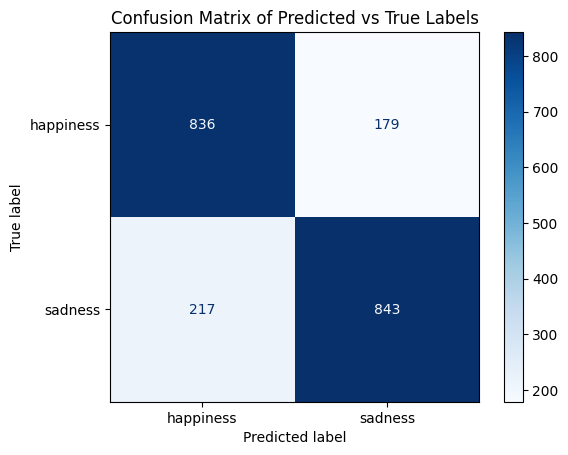

In [9]:
# Generate predictions for the test data
predicted_labels = classification_model.predict(test_sentences).argmax(axis=1)

# Display classification metrics
print("\nClassification Report:")
print(classification_report(
    test_labels, predicted_labels, target_names=label_names
))

# Display the confusion matrix with better visualization
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    test_labels, predicted_labels, display_labels=label_names, cmap="Blues"
)
plt.title('Confusion Matrix of Predicted vs True Labels')
plt.grid(False)  # Disable grid lines for a cleaner look
plt.show()


The results in the image show that your model works pretty well, with an accuracy of 81%. Both "happiness" and "sadness" have similar precision, recall, and F1-scores (around 0.81), which means the model predicts these emotions well overall. However, some mistakes are still happening, with quite a few "happiness" reviews getting classified as "sadness" and vice versa.

# Saving the Model

### This step saves the trained sentiment classification model as a file named `sentiment-for-nova.keras`, allowing for later reuse or deployment.

In [10]:
classification_model.save('sentiment-for-nova.keras')

# Sample Emotion Predictions

### Sample texts are processed to predict emotions, converting them for model input, predicting, and outputting each emotion label with its text. This provides a quick overview of model predictions.

In [11]:
sample_texts = [
    "I'm feeling so down today, nothing seems to go right.",
    "This is the best day ever! I just got promoted at work!",
    "I can't believe how terrible this service is. I'm never coming back!",
    "I really miss my family. It's been too long since we last saw each other.",
    "Wow! This food is absolutely delicious. I'm loving every bite!"
]

# Convert text to Pandas Series for compatibility with the model
text_series = pd.Series(sample_texts)

# Generate predictions using the model
predicted_emotions = classification_model.predict(text_series).argmax(axis=1)

# Convert predicted labels to their corresponding emotion names
predicted_labels = [label_names[pred] for pred in predicted_emotions]

# Print the predicted emotions
print("Predicted Emotions for Sample Texts:")
for text, emotion in zip(sample_texts, predicted_labels):
    print(f"Text: {text}\nPredicted Emotion: {emotion}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Emotions for Sample Texts:
Text: I'm feeling so down today, nothing seems to go right.
Predicted Emotion: sadness

Text: This is the best day ever! I just got promoted at work!
Predicted Emotion: happiness

Text: I can't believe how terrible this service is. I'm never coming back!
Predicted Emotion: sadness

Text: I really miss my family. It's been too long since we last saw each other.
Predicted Emotion: sadness

Text: Wow! This food is absolutely delicious. I'm loving every bite!
Predicted Emotion: happiness



# <font color="yellow">Functionality testing</font>


# Instructions for Running the Code
### Starting from This Section
#### You can run the code if you already have a trained model saved in a file from the steps above.

### How It Works
#### 1. The code will prompt you to enter the name of a product you want to search for.
#### 2. It will then automatically use Information Retrieval techniques in the browser to gather all the required information.

### Important Notes
#### Do not interact with the browser window during the process to avoid potential errors.
#### The script is designed to handle all actions autonomously.

# Amazon Product Review Scraper
### This script automates searching for products on Amazon, extracting product links, and scraping detailed reviews (name, content, and date) for analysis. It organizes the data into a structured format for easy use.

In [12]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time

browser = webdriver.Chrome()

def search_amazon(product_name):
    # Open Amazon homepage
    browser.get("https://www.amazon.com")
    browser.implicitly_wait(5)

    # Enter the product name in the search bar
    search_box = browser.find_element(By.ID, "twotabsearchtextbox")
    search_box.send_keys(product_name)
    search_box.send_keys(Keys.RETURN)
    # Wait for the search results to load
    time.sleep(3)

def get_product_links():
    # Wait for search results to load
    time.sleep(3)

    # Find product title containers
    product_elements = browser.find_elements(By.CSS_SELECTOR, 'h2.a-size-mini.a-spacing-none.a-color-base.s-line-clamp-4')
    product_links = []

    # Extract product names and links
    for product in product_elements:
        try:
            # Find the link within the title container
            link_element = product.find_element(By.CSS_SELECTOR, 'a.a-link-normal')
            link = link_element.get_attribute('href')
            name = link_element.find_element(By.TAG_NAME, 'span').text.strip()
            if link and name:
                product_links.append({"Name": name, "Link": link})
        except Exception as e:
            print(f"Error extracting product link: {e}")
            continue

    return product_links



def scrape_reviews(product_url):
    # Open the product page
    browser.get(product_url)
    time.sleep(3)

    # Scroll to load reviews
    browser.execute_script("window.scrollBy(0, 1500);")
    time.sleep(2)
    browser.execute_script("window.scrollBy(1500, 3000);")
    time.sleep(2)

    # Find all review elements
    reviews = browser.find_elements(By.CLASS_NAME, 'review')
    reviews_data = []

    for review in reviews:
        try:
            # Extract reviewer's info
            name = review.find_element(By.CLASS_NAME, 'a-profile-name').text.strip() if review.find_elements(By.CLASS_NAME, 'a-profile-name') else 'No Name'
            
            content = review.find_element(By.CLASS_NAME, 'a-expander-content').text.strip() if review.find_elements(By.CLASS_NAME, 'a-expander-content') else 'No Content'
            
            date = review.find_element(By.CLASS_NAME, 'review-date').text.strip() if review.find_elements(By.CLASS_NAME, 'review-date') else 'No Date'

            # Append review data
            reviews_data.append({
                'Reviewer': name,
                'Content': content,
                'Date': date
            })
        except:
            continue

    return reviews_data

product_name = input("Enter the product name to search: ")

# Search for the product
search_amazon(product_name)

# Get product links and names
product_links = get_product_links()
# Store all products and their reviews
all_data = []

# Iterate through each product and scrape reviews
# * Limit to 5 products for demonstration
for product in product_links[:5]:
    print(f"Scraping reviews for: {product['Name']}")
    reviews = scrape_reviews(product['Link'])
    all_data.append({
        "Name": product['Name'],
        "Link": product['Link'],
        "Reviews": reviews
    })

# Print or save the data
for product in all_data:
    print(f"Product: {product['Name']}")
    print(f"Link: {product['Link']}")
    print("Reviews:")
    for review in product['Reviews']:
        print(f"  Reviewer: {review['Reviewer']}")
        print(f"  Content: {review['Content']}")
        print(f"  Date: {review['Date']}")
        print("-" * 40)
    print("=" * 80)

# Close the browser
browser.quit()


Scraping reviews for: Fruit of the Loom Men's Eversoft Fleece Hoodies, Moisture Wicking & Breathable, Full Zip Hooded Sweatshirt
Scraping reviews for: EKLENTSON Men's Winter Jacket Thick Thermal Cotton Warm Fleece Lined Coat Trucker Lapel Work Cargo Jackets for Men
Scraping reviews for: Hanes Men's Zip-Up Hoodie, EcoSmart Fleece Full-Zip Hoodie for Men, Hooded Sweatshirt
Scraping reviews for: Yeokou Women's Casual Full Zip Up Sherpa Lined Hoodie Sweatshirt Jacket Coat
Scraping reviews for: Columbia Steens Mountain 2.0 Full Zip Fleece Jacket
Product: Fruit of the Loom Men's Eversoft Fleece Hoodies, Moisture Wicking & Breathable, Full Zip Hooded Sweatshirt
Link: https://www.amazon.com/Fruit-Loom-Eversoft-Sweatshirts-Zip-Black/dp/B08YH1VZKF/ref=sr_1_1?dib=eyJ2IjoiMSJ9.XZLZsRTq17v4b8m_VlzWfYzbLoboQ302EktIKICG0SNf_NIs-Wr7CwY2pPLXy2_ZwWdaHgIidEJyrFGTt1CZTh85D9kRXmhyx7q1Qixboj9BO3hrRCD2SH-bdgZxUC83GC3ZaJ3SD48VuwV1sAJZmASbG3hmczrd5Dz4d_l22p1QFz8Ffto-BHkd6E85Z2G0er69HQ92RfPTsrvpppSwQ6QvKndnVMuN

# Product Review Sentiment Analysis
### This script loads a pre-trained sentiment classification model, analyzes product reviews to classify sentiments (e.g., Positive, Negative, Neutral), and identifies the best product based on the ratio of positive reviews. The results are structured for easy comparison and analysis.

## Output
### The script provides a list of analyzed products with their respective sentiment distributions, showing how satisfied users are with each product.
### At the end, the script highlights the most relevant product based on user reviews, including its name, link, and overall satisfaction ratio.

In [ ]:
# Preparing Functions and Data for Predictions  
# Reinitializing necessary functions and data for predictions to avoid rerunning the entire training process.
import re
import pandas as pd
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile(r'[^0-9a-z #+_]')
NUMBERS_RE = re.compile(r'\d+')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(input_text):
    input_text = tf.strings.lower(input_text)
    input_text = tf.strings.regex_replace(input_text, r'http\S+', '')
    input_text = tf.strings.regex_replace(input_text, r'[@#][A-Za-z0-9_]+', ' ')
    input_text = tf.strings.regex_replace(input_text, REPLACE_BY_SPACE_RE.pattern, ' ')
    input_text = tf.strings.regex_replace(input_text, BAD_SYMBOLS_RE.pattern, '')
    input_text = tf.strings.regex_replace(input_text, NUMBERS_RE.pattern, '')
    return input_text

df = pd.read_csv(
    'tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)
df.rename(columns={'content': 'sentence', 'sentiment': 'label'}, inplace=True)
df = df[(df['label'] == 'sadness') | (df['label'] == 'happiness')]
df['label'] = df['label'].cat.remove_unused_categories()
label_names = df['label'].cat.categories.tolist()

In [13]:
from tensorflow.keras.models import load_model
import pandas as pd

def classify_reviews(all_data, classification_model, label_names):
    for product in all_data:
        # Convert review contents to a Pandas Series
        text_series = pd.Series([review['Content'] for review in product['Reviews']])

        # Run each review content through the classification model and get sentiment predictions
        # Get class with highest probability
        predictions = classification_model.predict(text_series).argmax(axis=1)
        # Map numerical predictions to label names
        predicted_labels = [label_names[pred] for pred in predictions]

        # Store sentiment predictions back into the reviews
        for i, review in enumerate(product['Reviews']):
            review['Sentiment'] = predicted_labels[i]

        # Add sentiment summary to the product
        sentiment_summary = pd.Series(predicted_labels).value_counts(normalize=True).to_dict()
        # Store overall sentiment distribution
        product['SentimentSummary'] = sentiment_summary

def find_best_product(all_data):
    best_product = None
    highest_positive_ratio = -1

    for product in all_data:
        sentiment_summary = product.get('SentimentSummary', {})
        positive_ratio = sentiment_summary.get('Positive', 0)  # Assuming 'Positive' is a sentiment label

        if positive_ratio > highest_positive_ratio:
            highest_positive_ratio = positive_ratio
            best_product = product

    return best_product

# Load the classification model from the file
classification_model = load_model(
    'sentiment-for-nova.keras',
    custom_objects={"preprocess_text": preprocess_text}
)

# Classify reviews for each product
classify_reviews(all_data, classification_model, label_names)

# Find the best product
best_product = find_best_product(all_data)

# Display results
print("Overall results:")
for product in all_data:
    print(f"Product: {product['Name']}")
    print(f"Link: {product['Link']}")
    print(f"Sentiment Ratio: {product['SentimentSummary']}")
    print("=" * 80)

if best_product:
    print("Best Product:")
    print(f"Name: {best_product['Name']}")
    print(f"Link: {best_product['Link']}")
    print(f"Overall Satisfaction: {best_product['SentimentSummary']}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Overall results:
Product: Fruit of the Loom Men's Eversoft Fleece Hoodies, Moisture Wicking & Breathable, Full Zip Hooded Sweatshirt
Link: https://www.amazon.com/Fruit-Loom-Eversoft-Sweatshirts-Zip-Black/dp/B08YH1VZKF/ref=sr_1_1?dib=eyJ2IjoiMSJ9.XZLZsRTq17v4b8m_VlzWfYzbLoboQ302EktIKICG0SNf_NIs-Wr7CwY2pPLXy2_ZwWdaHgIidEJyrFGTt1CZTh85D9kRXmhyx7q1Qixboj9BO3hrRCD2SH-bdgZxUC83GC3ZaJ3SD48VuwV1sAJZmASbG3hmczrd5Dz4d_l22p1QFz8Ffto-BHkd6E85Z2G0er69HQ92RfPTsrvpppSwQ6QvKndnVMuNm5eSk4ypewBbqXPPHmQ3WDdSvpg2sWUGMtyo-nUJcODniE7aqVwM3-LvQYaZiL19jcWPBBoQ958.qX6HLr2s4bb_bRyLwc9WnWUHa63rNVndpnOcf8t9EoM&dib_tag=se&keywords=jacket&qid=1731767152&sr=8-1
Sentiment Ratio: {'happiness': 0.9230769230769231, 'sadness': 0.07692307692307693}
Product: EKLENTSON Men's Winter Jacket Thick Thermal Cotton Warm Fleece Lined Coat Tru

### The Best Product  

After analyzing all the reviews, we have identified the **top product** based on user satisfaction and positive feedback:  

**Best Product:**  
- **Name:** Fruit of the Loom Men's Eversoft Fleece Hoodies, Moisture Wicking & Breathable, Full Zip Hooded Sweatshirt  
- **Link:** [View Product on Amazon](https://www.amazon.com/Fruit-Loom-Eversoft-Sweatshirts-Zip-Black/dp/B08YH1VZKF/ref=sr_1_1?dib=eyJ2IjoiMSJ9.XZLZsRTq17v4b8m_VlzWfYzbLoboQ302EktIKICG0SNf_NIs-Wr7CwY2pPLXy2_ZwWdaHgIidEJyrFGTt1CZTh85D9kRXmhyx7q1Qixboj9BO3hrRCD2SH-bdgZxUC83GC3ZaJ3SD48VuwV1sAJZmASbG3hmczrd5Dz4d_l22p1QFz8Ffto-BHkd6E85Z2G0er69HQ92RfPTsrvpppSwQ6QvKndnVMuNm5eSk4ypewBbqXPPHmQ3WDdSvpg2sWUGMtyo-nUJcODniE7aqVwM3-LvQYaZiL19jcWPBBoQ958.qX6HLr2s4bb_bRyLwc9WnWUHa63rNVndpnOcf8t9EoM&dib_tag=se&keywords=jacket&qid=1731767152&sr=8-1)  

**Overall Satisfaction:**  
- **Happiness:** 92.31%  
- **Sadness:** 7.69%  

This product stands out with overwhelmingly positive reviews and a high happiness ratio among users, making it the most recommended choice based on customer feedback.